link da base original: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0216972#pone-0216972-g001

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

df = pd.read_excel("/content/Data_emergency.xlsx")
df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2,...,36.6,100,2,Corneal abrasion,1,4,2,86,"5,00",1
1,1,1,56,12,3,2,right forearm burn,1,1,2,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,"3,95",1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,"1,00",1
3,1,2,71,8,1,1,ascites tapping,1,1,3,...,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,"9,83",1
4,1,2,58,4,3,1,"distension, abd",1,1,3,...,36.5,NaN,4,Ascites,1,5,8,109,"6,60",1


In [ ]:
df.shape

(1267, 24)

## 1. Classificação de Gravidade
Variáveis Relevantes: Sinais vitais (frequência cardíaca, temperatura, pressão arterial), nível de dor, tempo desde o início dos sintomas.
Abordagem: Modelos de classificação de múltiplas classes podem ser usados para classificar os casos em leves, moderados e graves.
Modelo: K-Nearest Neighbors (KNN), Support Vector Machine (SVM), ou redes neurais podem ser úteis aqui.
Métrica de Avaliação: Acurácia e F1-score são úteis para medir a eficácia da classificação.

In [ ]:
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     1267 non-null   int64 
 1   Sex                       1267 non-null   int64 
 2   Age                       1267 non-null   int64 
 3   Patients number per hour  1267 non-null   int64 
 4   Arrival mode              1267 non-null   int64 
 5   Injury                    1267 non-null   int64 
 6   Chief_complain            1267 non-null   object
 7   Mental                    1267 non-null   int64 
 8   Pain                      1267 non-null   int64 
 9   NRS_pain                  1267 non-null   object
 10  SBP                       1267 non-null   object
 11  DBP                       1267 non-null   object
 12  HR                        1267 non-null   object
 13  RR                        1267 non-null   object
 14  BT                      

In [ ]:
lista_cat = ['Group', 'Sex', 'Injury', 'Arrival mode', 'Mental', 'Pain', 'NRS_pain', 'KTAS_RN', 'Error_group', 'mistriage']
df[lista_cat] = df[lista_cat].astype('category')

In [ ]:
(df[['Age', 'HR', 'RR', 'Saturation', 'BT', 'SBP', 'DBP']]=='??').sum()

,0
Age,0
HR,20
RR,22
Saturation,9
BT,18
SBP,25
DBP,29


In [ ]:
for col in ['Age', 'HR', 'RR', 'Saturation', 'BT', 'SBP', 'DBP']:
    df[col].replace('??',np.NaN, inplace=True)

<ipython-input-106-602a31973570>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace('??',np.NaN, inplace=True)
<ipython-input-106-602a31973570>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].replace('??',np.NaN, inplace=True)


In [ ]:
lista_num = ['Age', 'HR', 'RR', 'Saturation', 'BT', 'SBP', 'DBP']
df[lista_num] = df[lista_num].astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Group                     1267 non-null   category
 1   Sex                       1267 non-null   category
 2   Age                       1267 non-null   float64 
 3   Patients number per hour  1267 non-null   int64   
 4   Arrival mode              1267 non-null   category
 5   Injury                    1267 non-null   category
 6   Chief_complain            1267 non-null   object  
 7   Mental                    1267 non-null   category
 8   Pain                      1267 non-null   category
 9   NRS_pain                  1267 non-null   category
 10  SBP                       1242 non-null   float64 
 11  DBP                       1238 non-null   float64 
 12  HR                        1247 non-null   float64 
 13  RR                        1245 non-null   float6

In [ ]:
(df['NRS_pain']=='#BOÞ!').sum()

556

In [ ]:
import numpy as np
df['NRS_pain'] = df["NRS_pain"].replace("#BOÞ!",np.NaN)

<ipython-input-109-e873ff62ad72>:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['NRS_pain'] = df["NRS_pain"].replace("#BOÞ!",np.NaN)


In [ ]:
df["NRS_pain"] = df.groupby(["mistriage", "KTAS_expert"])["NRS_pain"].transform(lambda x: x.fillna(x.mode()[0]))
df["Saturation"] = df.groupby(["mistriage", "KTAS_expert"])["Saturation"].transform(lambda x: x.fillna(x.mode()[0]))
df["Diagnosis in ED"] = df.groupby(["mistriage", "KTAS_expert"])["Diagnosis in ED"].transform(lambda x: x.fillna(x.mode()[0]))

<ipython-input-110-049fc98995ca>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["NRS_pain"] = df.groupby(["mistriage", "KTAS_expert"])["NRS_pain"].transform(lambda x: x.fillna(x.mode()[0]))
<ipython-input-110-049fc98995ca>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["Saturation"] = df.groupby(["mistriage", "KTAS_expert"])["Saturation"].transform(lambda x: x.fillna(x.mode()[0]))
<ipython-input-110-049fc98995ca>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a

In [ ]:
df.isnull().sum()

,0
Group,0
Sex,0
Age,0
Patients number per hour,0
Arrival mode,0
Injury,0
Chief_complain,0
Mental,0
Pain,0
NRS_pain,0


In [ ]:
df.columns[df.isnull().sum()>0]

Index(['SBP', 'DBP', 'HR', 'RR', 'BT'], dtype='object')

In [ ]:
lista_con = df.columns[df.isnull().sum()>0]
df[lista_con].describe([0.10,0.25,0.50,0.75,0.90]).apply(lambda s: s.apply('{0:.2f}'.format))

,SBP,DBP,HR,RR,BT
count,1242.00,1238.00,1247.00,1245.00,1249.00
mean,133.65,79.78,83.96,19.51,36.58
std,27.28,15.15,16.64,2.02,0.55
min,50.00,31.00,32.00,14.00,35.00
10%,100.00,60.00,64.00,16.00,36.00
25%,114.00,70.00,72.00,18.00,36.20
50%,130.00,80.00,82.00,20.00,36.50
75%,150.00,90.00,96.00,20.00,36.80
90%,168.00,100.00,106.00,20.00,37.20
max,275.00,160.00,148.00,30.00,41.00


In [ ]:
df["SBP"] = df.groupby(["mistriage", "KTAS_expert"])["SBP"].transform(lambda x: x.fillna(x.median()))
df["HR"] = df.groupby(["mistriage", "KTAS_expert"])["HR"].transform(lambda x: x.fillna(x.median()))
df["DBP"] = df.groupby(["mistriage", "KTAS_expert"])["DBP"].transform(lambda x: x.fillna(x.median()))
df["RR"] = df.groupby(["mistriage", "KTAS_expert"])["RR"].transform(lambda x: x.fillna(x.median()))
df["BT"] = df.groupby(["mistriage", "KTAS_expert"])["BT"].transform(lambda x: x.fillna(x.median()))

<ipython-input-112-dbd98cafb56a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["SBP"] = df.groupby(["mistriage", "KTAS_expert"])["SBP"].transform(lambda x: x.fillna(x.median()))
<ipython-input-112-dbd98cafb56a>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["HR"] = df.groupby(["mistriage", "KTAS_expert"])["HR"].transform(lambda x: x.fillna(x.median()))
<ipython-input-112-dbd98cafb56a>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and 

In [ ]:
df['KTAS_expert'].value_counts()

,count
KTAS_expert,
3,487
4,459
2,220
5,75
1,26


In [ ]:
df['KTAS_expert'].replace({1:0, 2:0, 3:0, 4:1, 5:1}, inplace=True)

<ipython-input-114-a875709d6af0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['KTAS_expert'].replace({1:0, 2:0, 3:0, 4:1, 5:1}, inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Group                     1267 non-null   category
 1   Sex                       1267 non-null   category
 2   Age                       1267 non-null   float64 
 3   Patients number per hour  1267 non-null   int64   
 4   Arrival mode              1267 non-null   category
 5   Injury                    1267 non-null   category
 6   Chief_complain            1267 non-null   object  
 7   Mental                    1267 non-null   category
 8   Pain                      1267 non-null   category
 9   NRS_pain                  1267 non-null   category
 10  SBP                       1267 non-null   float64 
 11  DBP                       1267 non-null   float64 
 12  HR                        1267 non-null   float64 
 13  RR                        1267 non-null   float6

In [ ]:
df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71.0,3,3,2,right ocular pain,1,1,2,...,36.6,100.0,2,Corneal abrasion,1,1,2,86,"5,00",1
1,1,1,56.0,12,3,2,right forearm burn,1,1,2,...,36.5,98.0,4,"Burn of hand, firts degree dorsum",1,1,4,64,"3,95",1
2,2,1,68.0,8,2,2,"arm pain, Lt",1,1,2,...,36.6,98.0,4,"Fracture of surgical neck of humerus, closed",2,1,4,862,"1,00",1
3,1,2,71.0,8,1,1,ascites tapping,1,1,3,...,36.5,98.0,4,Alcoholic liver cirrhosis with ascites,1,1,6,108,"9,83",1
4,1,2,58.0,4,3,1,"distension, abd",1,1,3,...,36.5,98.0,4,Ascites,1,1,8,109,"6,60",1


In [ ]:
df.KTAS_expert.value_counts()

,count
KTAS_expert,
0,733
1,534


In [ ]:
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage', 'New_Age', 'New_SBP', 'New_DBP',
       'New_HR', 'New_RR', 'New_BT', 'New_NRS_pain', 'New_KTAS_duration_min',
       'New_Length_of_stay_min'],
      dtype='object')

In [ ]:
df_gravidade = df[['Sex','Age','Injury','HR','RR','BT','SBP','DBP','NRS_pain','KTAS_expert']]


In [ ]:
X = df_gravidade.drop('KTAS_expert', axis=1)
y = df_gravidade['KTAS_expert']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
df_gravidade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sex          1267 non-null   category
 1   Age          1267 non-null   int64   
 2   Injury       1267 non-null   category
 3   HR           1267 non-null   float64 
 4   RR           1267 non-null   float64 
 5   BT           1267 non-null   float64 
 6   SBP          1267 non-null   float64 
 7   DBP          1267 non-null   float64 
 8   NRS_pain     1267 non-null   category
 9   KTAS_expert  1267 non-null   int64   
dtypes: category(3), float64(5), int64(2)
memory usage: 73.7 KB


In [ ]:
# Preprocessando os dados para usar o modelo XGBoost
encoder = LabelEncoder()

for col in ['Sex', 'Injury', 'NRS_pain']:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

        X_train[col] = encoder.fit_transform(X_train[col])
        X_test[col] = encoder.transform(X_test[col])

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
X_test['Age'] = X_test['Age'].astype(float)

In [ ]:
pred = model_xgb.predict(X_test)

In [ ]:
confusion_matrix(y_test, pred)

array([[178,  41],
       [ 47, 115]])

In [ ]:
accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)

(0.7690288713910761,
 0.7371794871794872,
 0.7098765432098766,
 0.7232704402515723)

In [ ]:
# Tentaremos melhorar a acurácua do modelo.
# Implementando a validação cruzada para escolher os melhores hiperparâmetros do XGBoost.
parameters = {"learning_rate": [0.1, 0.01],
              "max_depth": [3, 5, 8],
              "n_estimators": [200, 500, 1000],
              "colsample_bytree": [0.7, 1]} #[{'C': [0.25, 0.5, 0.75, 1], 'penalty': ['l1', 'l2']}]

grid_search = GridSearchCV(estimator = model_xgb,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 8],
                         'n_estimators': [200, 500, 1000]},
             scoring='accuracy')

In [ ]:
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best Score:  0.7595696057893735


In [ ]:
xgb_best = xgb.XGBClassifier(colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200)

In [ ]:
xgb_best.fit(X_train, y_train)
accuracy_score(y_test, xgb_best.predict(X_test))

0.7742782152230971

In [ ]:
# Observamos pouca melhoria. Ficaremos com os hiperparâmetro iniciais do XGBoost
accuracy_score(y_test, xgb_best.predict(X_test)), precision_score(y_test, xgb_best.predict(X_test)), recall_score(y_test, xgb_best.predict(X_test)), f1_score(y_test, xgb_best.predict(X_test))

(0.7742782152230971,
 0.7753623188405797,
 0.6604938271604939,
 0.7133333333333334)

In [ ]:
# Ramdom forest
model_rf = RandomForestClassifier()
#model_rf.fit(X_train, y_train)

rf_params = {"max_depth": [3, 5, 8],
             "max_features": [8, 15, 25],
             "n_estimators": [200, 500, 1000],
             "min_samples_split": [2, 5, 10]}


In [ ]:
gs_cv_rf = GridSearchCV(model_rf, rf_params, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
print(gs_cv_rf.best_params_)
gs_cv_rf.best_score_

{'max_depth': 8, 'max_features': 15, 'min_samples_split': 10, 'n_estimators': 500}


0.7573287627753443

In [ ]:
model_rf = RandomForestClassifier(max_depth=8, max_features=15, min_samples_split=10,
                       n_estimators=500)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=15, min_samples_split=10,
                       n_estimators=500)

In [ ]:
confusion_matrix(y_test, model_rf.predict(X_test))

array([[172,  47],
       [ 43, 119]])

In [ ]:
accuracy_score(y_test, model_rf.predict(X_test))

0.7637795275590551

In [ ]:
model_rf_best = RandomForestClassifier(max_depth=8, max_features=15, min_samples_split=10,
                       n_estimators=50)
model_rf_best.fit(X_train, y_train)
accuracy_score(y_test, model_rf_best.predict(X_test))

0.7742782152230971

In [ ]:
accuracy_score(y_test, model_rf_best.predict(X_test)), precision_score(y_test, model_rf_best.predict(X_test)), recall_score(y_test, model_rf_best.predict(X_test)), f1_score(y_test, model_rf_best.predict(X_test))

(0.7742782152230971,
 0.7317073170731707,
 0.7407407407407407,
 0.7361963190184049)

In [ ]:
# Árvore de decisão
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
accuracy_score(y_test, model_dt.predict(X_test))

0.6666666666666666

In [ ]:
parameters = {'max_depth': [3, 5, 7, 10]}

In [ ]:
grid_search_DT = GridSearchCV(estimator = model_dt,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

In [ ]:
grid_search_DT.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10]}, scoring='accuracy')

In [ ]:
print(grid_search_DT.best_params_)
grid_search_DT.best_score_

{'max_depth': 7}


0.7133498381260711

In [ ]:
model_dt_best = DecisionTreeClassifier(max_depth=7)
model_dt_best.fit(X_train, y_train)
accuracy_score(y_test, model_dt_best.predict(X_test))

0.7296587926509186

In [ ]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
accuracy_score(y_test, model_LR.predict(X_test))

0.7007874015748031

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_SVM = SVC(gamma='auto')
model_SVM.fit(X_train, y_train)

SVC(gamma='auto')

In [ ]:
accuracy_score(y_test, model_SVM.predict(X_test))

0.5669291338582677

In [ ]:
parametros_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [ ]:
grid = GridSearchCV(model_SVM, parametros_svm, refit = True, verbose = 3)

In [ ]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.579 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.582 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.582 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.582 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.576 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.579 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.582 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.582 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.582 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.576 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.579 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(gamma='auto'),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
print("Best Hyperparameters: ", grid.best_params_)
print("Best Score: ", grid.best_score_)

Best Hyperparameters:  {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:  0.732489049704818


In [ ]:
model_SVM = SVC(C=100, gamma=0.0001, kernel='rbf')
model_SVM.fit(X_train, y_train)

SVC(C=100, gamma=0.0001)

In [ ]:
confusion_matrix(y_test, model_SVM.predict(X_test))

array([[181,  38],
       [ 71,  91]])

In [ ]:
accuracy_score(y_test, model_SVM.predict(X_test)), precision_score(y_test, model_SVM.predict(X_test)), recall_score(y_test, model_SVM.predict(X_test)), f1_score(y_test, model_SVM.predict(X_test))

(0.7139107611548556,
 0.7054263565891473,
 0.5617283950617284,
 0.6254295532646048)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
modelo_Knn = KNeighborsClassifier()

In [ ]:
modelo_Knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
confusion_matrix(y_test, modelo_Knn.predict(X_test))

array([[172,  47],
       [107,  55]])

In [ ]:
para_Knn = {'p':[1,2], 'n_neighbors':[3,5,7,9,13,21,51,61,71,81,91,101]}

In [ ]:
grid_Knn = GridSearchCV(estimator=modelo_Knn,
                           param_grid=para_Knn,
                           cv=5)

In [ ]:
grid_Knn.fit(X, y)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 13, 21, 51, 61, 71, 81, 91,
                                         101],
                         'p': [1, 2]})

In [ ]:
print("Best Hyperparameters: ", grid_Knn.best_params_)
print("Best Score: ", grid_Knn.best_score_)

Best Hyperparameters:  {'n_neighbors': 51, 'p': 1}
Best Score:  0.6188011577604183


In [ ]:
modelo_Knn = KNeighborsClassifier(n_neighbors=51, p=1)
modelo_Knn.fit(X_train, y_train)
accuracy_score(y_test, modelo_Knn.predict(X_test))

0.6482939632545932

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense


In [ ]:
X.shape

(1267, 9)

In [ ]:
# Ann
model_ann = Sequential()
model_ann.add(Dense(4, input_dim=9, activation='relu'))
model_ann.add(Dense(4, activation='relu'))
model_ann.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_ann.fit(X_train, y_train, epochs=1000, batch_size=10)

Epoch 1/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6171 - loss: 0.6569
Epoch 2/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6623 - loss: 0.6248
Epoch 3/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 0.6337
Epoch 4/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6067 - loss: 0.6458
Epoch 5/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6100 - loss: 0.6519
Epoch 6/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6101 - loss: 0.6624
Epoch 7/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6118 - loss: 0.6472
Epoch 8/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6194 - loss: 0.6291
Epoch 9/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6248 - loss: 0.6368
Epoch 10/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6081 - loss: 0.6559
Epoch 11/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6373 - loss: 0.6433
Epoch 12/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
pred = (model_ann.predict(X_test) >= 0.5).reshape(-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)

(0.7637795275590551, 0.702247191011236, 0.7716049382716049, 0.7352941176470589)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)
accuracy_score(y_test, model_NB.predict(X_test)), precision_score(y_test, model_NB.predict(X_test)), recall_score(y_test, model_NB.predict(X_test)), f1_score(y_test, model_NB.predict(X_test))

(0.7375328083989501,
 0.7583333333333333,
 0.5617283950617284,
 0.6453900709219859)

In [ ]:
dictionario = {'modelo':['Naive Bayes','ANN','RF','xgb'], 'accuracy':[0.74,0.76,0.77,0.77], 'precision':[0.76,0.70,0.73,0.74], 'recall':[0.56,0.77,0.74,0.71], 'f1':[0.65,0.74,0.74,0.72]}
resultado = pd.DataFrame(dictionario)

In [ ]:
resultado

,modelo,accuracy,precision,recall,f1
0,Naive Bayes,0.74,0.76,0.56,0.65
1,ANN,0.76,0.70,0.77,0.74
2,RF,0.77,0.73,0.74,0.74
3,xgb,0.77,0.74,0.71,0.72


<Axes: xlabel='modelo', ylabel='accuracy'>

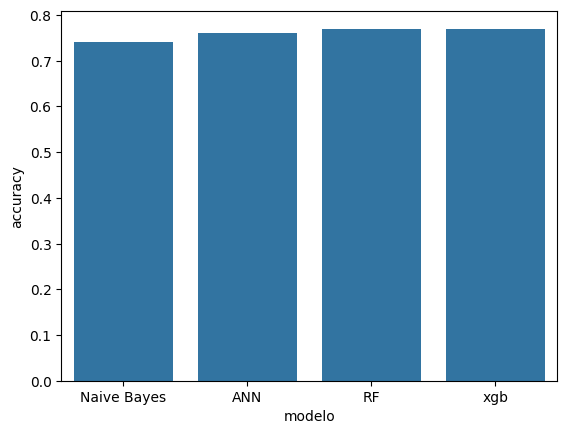

In [ ]:
sns.barplot(data=resultado, x='modelo', y='accuracy', )

In [ ]:
pivo = pd.melt(resultado, id_vars=['modelo'], value_vars=['accuracy', 'precision', 'recall', 'f1'])

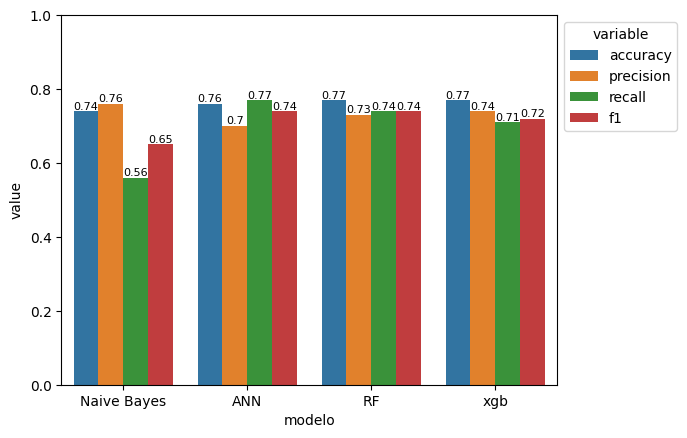

In [ ]:
ax = sns.barplot(data=pivo, x='modelo', y='value', hue='variable')
ax.bar_label(ax.containers[0], fontsize=8)
ax.bar_label(ax.containers[1], fontsize=8)
ax.bar_label(ax.containers[2], fontsize=8)
ax.bar_label(ax.containers[3], fontsize=8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylim([0,1]);

## 2. Previsão de Tempo de Permanência no Pronto-Socorro
Variáveis Relevantes: Dados de triagem e histórico médico, além de dados sobre o atendimento no pronto-socorro.
Abordagem: Um problema de regressão onde a variável alvo é o tempo de permanência (em horas ou minutos).
Modelo: Modelos de regressão como Linear Regression, Rede neural artificial para prever a duração da estadia.
Métrica de Avaliação: Métricas como RMSE (Root Mean Squared Error) e MAE (Mean Absolute Error).

In [ ]:
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage'],
      dtype='object')

In [ ]:
X = df[['Sex', 'Patients number per hour', 'Age','Injury','HR','RR','BT','SBP','DBP','NRS_pain','KTAS_expert']]
y = df['Length of stay_min']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
model_LineaR = LinearRegression()

In [ ]:
model_LineaR.fit(X_train, y_train)

LinearRegression()

In [ ]:
r2_score(y_test, model_LineaR.predict(X_test))

0.006085394371676323

In [ ]:
model_LineaR.coef_

array([ 3131.75582709,  1142.35155739,   -99.46810727, -4770.3747506 ,
         -91.93769929,  2283.15931891, -8851.86388728,  -180.01893198,
         275.972317  ,  -185.5266447 , -6209.46313508])

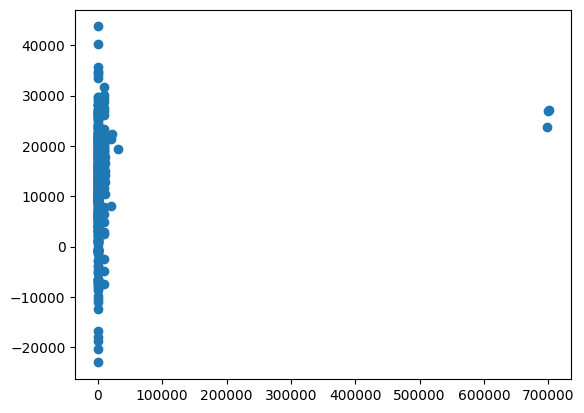

In [ ]:
plt.scatter(y_test, model_LineaR.predict(X_test))

In [ ]:
X.shape

(1267, 11)

In [ ]:
# Modelo ANN
model_ann = Sequential()
model_ann.add(Dense(5, input_dim=11, activation='relu'))
model_ann.add(Dense(5, activation='relu'))
model_ann.add(Dense(1, activation='linear'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
encoder = LabelEncoder()

for col in ['Sex', 'Injury', 'NRS_pain','KTAS_expert']:
    if col in X_train.columns and col in X_test.columns:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

        X_train[col] = encoder.fit_transform(X_train[col])
        X_test[col] = encoder.transform(X_test[col])
    elif col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
        X_train[col] = encoder.fit_transform(X_train[col])
    elif col in X_test.columns:
        X_test[col] = X_test[col].astype(str)
        X_test[col] = encoder.transform(X_test[col])

In [ ]:
model_ann.compile(loss='mean_squared_error', optimizer='adam')
model_ann.fit(X_train, y_train, epochs=500, batch_size=10)

Epoch 1/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 8722727936.0000
Epoch 2/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 8727631872.0000
Epoch 3/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 7728263680.0000
Epoch 4/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 5101915136.0000
Epoch 5/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 6807707136.0000
Epoch 6/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 7193988096.0000
Epoch 7/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 12714848256.0000
Epoch 8/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 6366962688.0000
Epoch 9/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 7065180672.0000
Epoch 10/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 3211203072.0000
Epoch 11/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 10137072640.0000
Epoch 12/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 11633103872.0000
Epoch 13/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 82307778

In [ ]:
# Resultado insafisfatório com a métrica R2
r2_score(y_test, model_ann.predict(X_test))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


-0.006605863571166992

## 3. Identificação de Padrões de Sintomas e Diagnósticos
Variáveis Relevantes: Sintomas relatados, sinais vitais, dados de histórico médico.
Abordagem: Técnicas de clustering ou associação podem ser usadas para identificar padrões frequentes entre os sintomas e diagnósticos.
Modelo: Algoritmos de agrupamento como K-Means, DBSCAN. Métrica de Avaliação: Avaliação qualitativa dos grupos formados, ou métricas como silhouette score para clusterização.

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
       'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP',
       'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED',
       'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min',
       'KTAS duration_min', 'mistriage'],
      dtype='object')

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

categorical_features = df.select_dtypes(include=['object', 'category']).columns

encoder = LabelEncoder()

for col in categorical_features:
    df[col] = df[col].astype(str)
    df[col] = encoder.fit_transform(df[col])

df_dum = pd.get_dummies(df, columns=categorical_features)

# modelo DBSCAN
modelo_DBSCAN = DBSCAN(metric='euclidean')
modelo_DBSCAN.fit(df_dum)

DBSCAN()

In [ ]:
# Modelo K-means
modelo_kmeans = KMeans(n_clusters=2)
modelo_kmeans.fit(df_dum)

KMeans(n_clusters=2)

In [ ]:
np.unique(modelo_kmeans.labels_)

array([0, 1], dtype=int32)

In [ ]:
df['cluster'] = modelo_kmeans.labels_

In [ ]:
df['KTAS_expert'][df['cluster']==1].value_counts()

,count
KTAS_expert,
0,13
1,4
